# Compare the amplitudes from all of the vkdv scenarios

| Test No. | Name | Density Model | a0 Model     |
| -------- | ------------------ | ------------- | ------------ |
| 1        |  harmo_a0_data_rho   | in situ       | harmonics    |
| 2        |  stoch_a0_data_rho | in situ       | harmonics+AR |
| 3        |  harmo_a0_clim_rho | seasonal      | harmonics    |
| 4        |  stoch_a0_clim_rho | seasonal      | harmonics+AR |

In [1]:
# !ls -lah ../output/*v4*.nc

In [2]:
# vkdvfile = '../output/2021-04-07--05-27-46_slim-harmo_a0_clim_rho_v2_magnus_kdv_runs.nc'
# sitename = 'harmo_a0_clim_rho_v2'

# vkdvfile = '../output/2021-04-07--05-26-47_slim-harmo_a0_data_rho_v2_magnus_kdv_runs.nc'
# sitename = 'harmo_a0_data_rho'

# vkdvfile = '../outputs/2021-04-08--01-31-31_slim-stoch_a0_clim_rho_v3_magnus_kdv_runs.nc'
# sitename = 'stoch_a0_clim_rho'

# vkdvfile = '../output/2021-04-06--23-57-18_slim-stoch_a0_data_rho_v2_magnus_kdv_runs.nc'
# sitename = 'stoch_a0_data_rho'

# vkdvfiles = {
#     'harmo_a0_data_rho':'../outputs/2021-04-08--01-30-37_slim-harmo_a0_data_rho_v3_magnus_kdv_runs.nc',
#     'harmo_a0_clim_rho':'../outputs/2021-04-08--01-29-08_slim-harmo_a0_clim_rho_v3_magnus_kdv_runs.nc',
#     'stoch_a0_clim_rho':'../outputs/2021-04-08--01-31-31_slim-stoch_a0_clim_rho_v3_magnus_kdv_runs.nc',
#     'stoch_a0_data_rho':'../outputs/2021-04-08--01-34-42_slim-stoch_a0_data_rho_v3_magnus_kdv_runs.nc',
#     'seasonal_a0_clim_rho':'../outputs/2021-05-11--12-51-40_slim-seasonal_a0_clim_rho_v3_magnus_kdv_runs.nc',
#     'seasonal_a0_data_rho':'../outputs/2021-05-11--12-50-26_slim-seasonal_a0_data_rho_v3_magnus_kdv_runs.nc',   
# }

# vkdvfiles = {
#     'harmo_a0_data_rho':'../output/2021-08-02--07-08-49_slim-harmo_a0_data_rho_v4_magnus_kdv_runs.nc',
#     'harmo_a0_clim_rho':'../output/2021-08-02--07-09-41_slim-harmo_a0_clim_rho_v4_magnus_kdv_runs.nc',
#     'seasonal_a0_clim_rho':'../output/2021-08-02--07-06-20_slim-seasonal_a0_clim_rho_v4_magnus_kdv_runs.nc',
#     'seasonal_a0_data_rho':'../output/2021-08-02--07-07-39_slim-seasonal_a0_data_rho_v4_magnus_kdv_runs.nc',   
# }
datadir = '../../../KDV/output/'
vkdvfiles = {
    'harmo_a0_data_rho':'{}/2021-09-09--08-16-36_slim-harmo_a0_data_rho_v4_magnus_kdv_runs.nc'.format(datadir),
    'harmo_a0_clim_rho':'{}/2021-09-09--08-15-46_slim-harmo_a0_clim_rho_v4_magnus_kdv_runs.nc'.format(datadir),
    'seasonal_a0_clim_rho':'{}/2021-09-09--08-18-10_slim-seasonal_a0_data_rho_v4_magnus_kdv_runs.nc'.format(datadir),
    'seasonal_a0_data_rho':'{}/2021-09-09--08-17-24_slim-seasonal_a0_clim_rho_v4_magnus_kdv_runs.nc'.format(datadir),   
}
# names = ['harmo_a0_data_rho','harmo_a0_clim_rho','seasonal_a0_clim_rho','seasonal_a0_data_rho']
names = ['tidal_eta_subseas_rho','tidal_eta_seas_rho','seasonal_eta_subseas_rho','seasonal_eta_seas_rho']

In [3]:
from sfoda.utils.othertime import SecondsSince

from datetime import datetime
from scipy.interpolate import interp1d
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import h5py
# import seaborn as sns

import matplotlib.dates as mdates

/opt/tljh/user/lib/python3.7/site-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.11) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


In [4]:
plt.rcParams['font.size'] = 14
plt.rcParams['axes.labelsize'] = 'medium'

In [5]:
def min_amplitude_finder(amp_signal):
    amp_min = np.nanmin(amp_signal)
    return amp_min, np.argwhere(amp_signal==amp_min)[0][0]
    
def maximum_amplitude_finder(amp_signal):
    amp_min = np.nanmin(amp_signal)
    amp_max = np.nanmax(amp_signal)
    if np.abs(amp_min)>amp_max:
        return amp_min, np.argwhere(amp_signal==amp_min)[0][0]
    else:
        return amp_max, np.argwhere(amp_signal==amp_max)[0][0]

In [6]:
# Validate the amplitude also...
###########
#basedir = 'C:\Projects\ARCHub\DATA\FIELD\ShellCrux\'

# basedir = '/home/mrayson/group/mrayson/DATA/FIELD/ShellCrux/'
basedir = '/data-obs/jupyter-ubuntu/Crux/'

#ncfile = '/home/suntans/Projects/ARCHub/DATA/FIELD/ShellCrux/KP150_Fitted_Buoyancy_wout_motion.nc'
# basedir = '/home/suntans/cloudstor/Data/Crux/'
ncfile = '{}/KP150_Fitted_Buoyancy_wout_motion_unvenfilt.nc'.format(basedir)
freq = '24H'
mode = 0
###########

ds1 = xr.open_dataset(ncfile,group='KP150_phs1')
ds2 = xr.open_dataset(ncfile,group='KP150_phs2')

# Merge the two

A_n = xr.concat([ds1['A_n'][:,mode],ds2['A_n'][:,mode]], dim='time')
#a0 = xr.concat([ds1['amp'][:,mode,0],ds2['amp'][:,mode,0]], dim='timeslow')

# Quality control
A_n.loc['2016-09-18':'2016-10-31']=np.nan

time1 = pd.date_range('2016-5-1','2016-9-15',freq=freq) 
time2 = pd.date_range('2016-11-1','2017-5-1',freq=freq)
timemax = time1.append(time2)

Amax_all = []
Amax_time = []
for t1,t2 in zip(timemax[0:-1],timemax[1::]):
    #t2 = t1 + np.timedelta64(1,'D')
    
    #Amax, tidx = maximum_amplitude_finder(A_n.sel(time=slice(t1,t2)).values)
    Amax, tidx = min_amplitude_finder(A_n.sel(time=slice(t1,t2)).values)

    tmax = A_n.sel(time=slice(t1,t2)).time[tidx].values
    Amax_all.append(Amax)
    Amax_time.append(tmax)

#ds_A = pd.Series(Amax_all, index=Amax_time)
ds_A = xr.DataArray(Amax_all, coords={'time':Amax_time}, dims=('time',))


In [7]:
def load_vkdv(vkdvfile):
    dskdv = xr.open_dataset(vkdvfile)
    idx = dskdv.time > np.datetime64('2030-01-01')
    ds = dskdv.isel({'time':~idx})
    return ds

In [8]:
# Calculate the probability
def calc_Aprob(ds):
    Abins = np.arange(0,85,2.5)
    na = Abins.shape[0]
    nt = ds.time.shape[0]
    nsamples = ds.ensemble.shape[0]
    Aprob = np.zeros((na, nt))
    for ii,aa in enumerate(Abins):
        idx_kdv  = np.abs(ds.amax.values) > aa
        plarge = idx_kdv.sum(axis=0)/nsamples * 100

        Aprob[ii,:] = plarge

    time=ds.time.values
    return Aprob, Abins, time

def plot_vkdv_prob(vkdvfile):
    Aprob, Abins, time = calc_Aprob(load_vkdv(vkdvfile))
    
    plt.contourf(time, Abins, Aprob, [1,5,25,50,75,95,99],  cmap='inferno', extend='max')
    plt.plot(ds_A['time'], np.abs(ds_A.values),'x',color='r', ms=2, alpha=0.9)
    plt.xlim(time[0],time[-1])
    plt.ylabel('$|A|$ [m]')
    plt.colorbar()
    plt.grid(b=True,ls=':')
    
    return Aprob, time

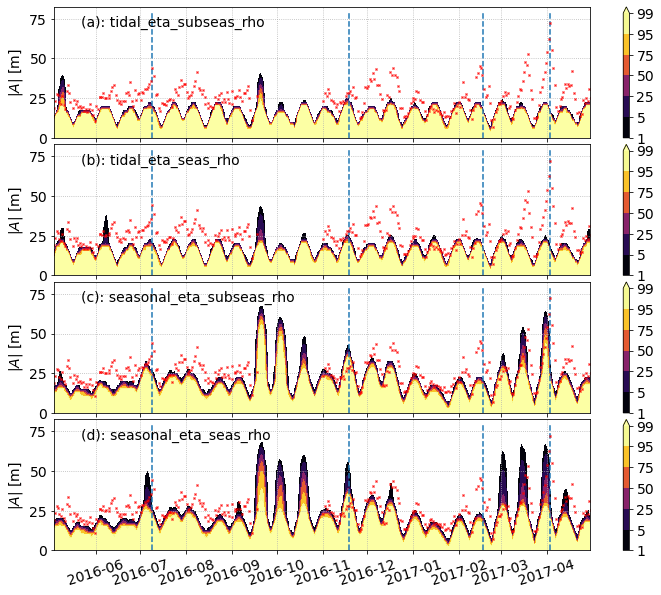

In [9]:
plt.figure(figsize=(12,10))
#plt.pcolormesh(ds.time.values, Abins, Aprob)
# plt.contourf(ds.time.values, Abins, Aprob, [1,5,25,50,75,95,99], cmap='gray_r', extend='min')
ax = plt.subplot(411)
_, time = plot_vkdv_prob(vkdvfiles['harmo_a0_data_rho'])
ax.set_xticklabels([])
plt.text(0.05,0.85,'(a): {}'.format(names[0]),transform=ax.transAxes)
plt.vlines(time[[66,199,289,334]], ymin=0, ymax=80,ls='--')

ax = plt.subplot(412)
plot_vkdv_prob(vkdvfiles['harmo_a0_clim_rho'])
ax.set_xticklabels([])
plt.text(0.05,0.85,'(b): {}'.format(names[1]),transform=ax.transAxes)
plt.vlines(time[[66,199,289,334]], ymin=0, ymax=80,ls='--')

ax = plt.subplot(413)
plot_vkdv_prob(vkdvfiles['seasonal_a0_clim_rho'])
ax.set_xticklabels([])
plt.text(0.05,0.85,'(c): {}'.format(names[2]),transform=ax.transAxes)
plt.vlines(time[[66,199,289,334]], ymin=0, ymax=80,ls='--')

ax = plt.subplot(414)
plot_vkdv_prob(vkdvfiles['seasonal_a0_data_rho'])
plt.xticks(rotation=17)
plt.text(0.05,0.85,'(d): {}'.format(names[3]),transform=ax.transAxes)
plt.vlines(time[[66,199,289,334]], ymin=0, ymax=80,ls='--')
plt.subplots_adjust(wspace=0, hspace=0.05)

plt.savefig('../FIGURES/vkdv_Aprob_v6.png', dpi=150)
plt.savefig('../FIGURES/vkdv_Aprob_v6.pdf', dpi=150)

# Count the number of points within each credible interval

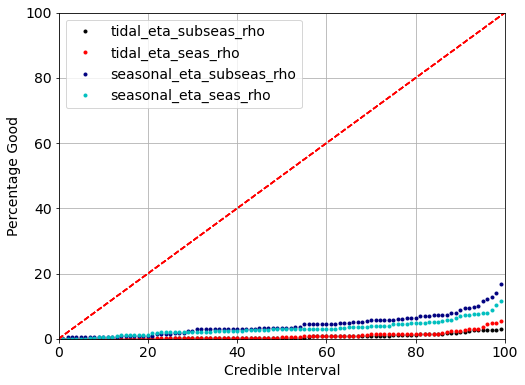

In [10]:
# Interplate p95 and p5 onto the observation points

def calc_credint(dskdv, credint, returnminmax=False):

    lowval = (100-credint)/2
    highval = 100-(100-credint)/2 

    amax_min = np.nanpercentile(dskdv.amax,lowval, axis=0)
    amax_max = np.nanpercentile(dskdv.amax,highval, axis=0)

    tsec = SecondsSince(time)
    tsec_i = SecondsSince(ds_A['time'].values)

    Fmax = interp1d(tsec, amax_max, bounds_error=False)
    Fmin = interp1d(tsec, amax_min, bounds_error=False)

    amax_min_i = Fmin(tsec_i)
    amax_max_i = Fmax(tsec_i)

    idx_in = (ds_A.values > amax_min_i) & (ds_A.values < amax_max_i)

    nt = tsec_i.shape[0]
    #, lowval, highval
    if returnminmax:
        return np.sum(idx_in)/nt * 100,amax_min_i,amax_max_i

    else:
        return np.sum(idx_in)/nt * 100


def plot_in_cred_int(vkdvfile, c):

    dskdv = load_vkdv(vkdvfile)

    credint = range(1,100)
    perc_in = [calc_credint(dskdv, ii) for ii in credint]

    p1= plt.plot(credint, perc_in,'.',color=c)
    plt.plot([0,100],[0,100],'r--')
    plt.ylim(0,100)
    plt.xlim(0,100)
    plt.ylabel('Percentage Good')
    plt.xlabel('Credible Interval')
    plt.grid(b=True)
    return p1[0]
    
colors = ['k','r','navy','c']

plt.figure(figsize=(8,6))
p1=plot_in_cred_int(vkdvfiles['harmo_a0_data_rho'], colors[0])
p2=plot_in_cred_int(vkdvfiles['harmo_a0_clim_rho'], colors[1])
p3=plot_in_cred_int(vkdvfiles['seasonal_a0_data_rho'], colors[2])
p4=plot_in_cred_int(vkdvfiles['seasonal_a0_clim_rho'], colors[3])
plt.legend((p1,p2,p3,p4), names, loc='upper left')

plt.savefig('../FIGURES/vkdv_perc_good_v2.png', dpi=150)
plt.savefig('../FIGURES/vkdv_perc_good_v2.pdf', dpi=150)

In [27]:
p1

# Compute the Brier skill score

There are various scoring rules for models where the output is expressed in terms of probability. Mean square error is probably the most common, although is primarily suited to situations where the posterior distribution is Gaussian. For non-Gaussian cases, the log probability is more suited (see e.g. Gelman 2014).

Here, we are more interested in whether a theshold value is reached i.e. whether $A_{max}>y$. The Brier score is suited to binary events e.g. rain/no rain or $P(A_{max}>y)>0$.

(0.0, 1.0)

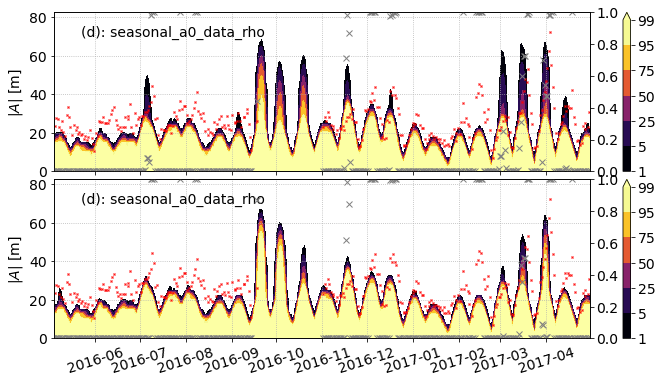

In [81]:

#A_obs = ds_A.sel(time=mytime, method='nearest')


def brier_score(Y, y, thresh):
    ft = (Y>thresh).astype(float)
    sigmat = (y>thresh).astype(float)
    return 1/N * np.sum((ft-sigmat)**2)


def calc_brier(ds, thresh):
    time = ds_A.time
    nt = time.values.shape[0]
    B = np.zeros((nt,))
    for ii,t in enumerate(time.values):
        Y = np.abs(ds.amax.sel(time=t, method='nearest').values)
        A_obs=ds_A.sel(time=t, method='nearest')
        y = np.abs(A_obs.values)
        N = Y.shape[0]
        B[ii] = brier_score(Y,y,thresh)
        
    return B

ds = load_vkdv(vkdvfiles[scenario])
thresh = 35

#B = calc_brier(ds, thresh)
    
plt.figure(figsize=(12,6))

ax = plt.subplot(211)
scenario = 'seasonal_a0_clim_rho'
plot_vkdv_prob(vkdvfiles[scenario])
plt.xticks(rotation=17)
plt.text(0.05,0.85,'(d): {}'.format(names[3]),transform=ax.transAxes)
# plt.vlines(time[[66,199,289,334]], ymin=0, ymax=80,ls='--')
plt.subplots_adjust(wspace=0, hspace=0.05)
ax2=ax.twinx()
ax2.plot(ds_A.time, calc_brier(load_vkdv(vkdvfiles[scenario]), thresh) ,'x',c='0.5')
ax2.set_ylim(0,1)

ax = plt.subplot(212)
scenario = 'seasonal_a0_data_rho'
plot_vkdv_prob(vkdvfiles[scenario])
plt.xticks(rotation=17)
plt.text(0.05,0.85,'(d): {}'.format(names[3]),transform=ax.transAxes)
# plt.vlines(time[[66,199,289,334]], ymin=0, ymax=80,ls='--')
plt.subplots_adjust(wspace=0, hspace=0.05)
ax2=ax.twinx()
ax2.plot(ds_A.time, calc_brier(load_vkdv(vkdvfiles[scenario]), thresh) ,'x',c='0.5')
ax2.set_ylim(0,1)

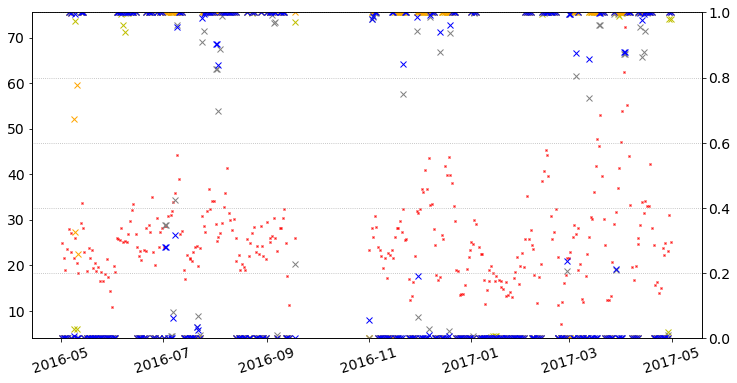

In [83]:
###
thresh=25

plt.figure(figsize=(12,6))

ax = plt.subplot(111)
plt.plot(ds_A['time'], np.abs(ds_A.values),'x',color='r', ms=2, alpha=0.9)
plt.xticks(rotation=17)
# plt.text(0.05,0.85,'(d): {}'.format(names[3]),transform=ax.transAxes)
ax2=ax.twinx()
ax2.plot(ds_A.time, calc_brier(load_vkdv(vkdvfiles['harmo_a0_clim_rho']), thresh) ,'x',c='y')
ax2.plot(ds_A.time, calc_brier(load_vkdv(vkdvfiles['harmo_a0_data_rho']), thresh) ,'x',c='orange')
ax2.plot(ds_A.time, calc_brier(load_vkdv(vkdvfiles['seasonal_a0_clim_rho']), thresh) ,'x',c='0.5')
ax2.plot(ds_A.time, calc_brier(load_vkdv(vkdvfiles['seasonal_a0_data_rho']), thresh) ,'x',c='b')

ax2.set_ylim(0,1)
plt.grid(b=True, ls=':')

(array([16953., 16983., 17014., 17045., 17075., 17106., 17136., 17167.,
        17198., 17226., 17257.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

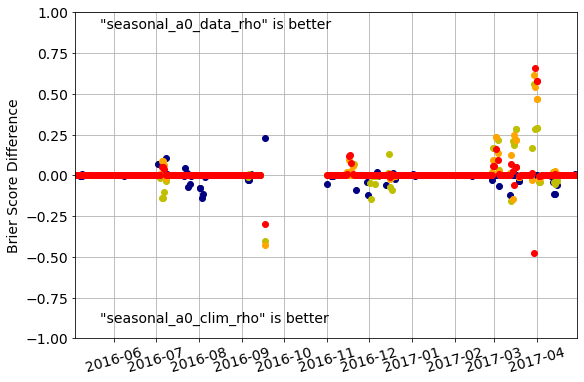

In [85]:
plt.figure(figsize=(9,6))
ax=plt.subplot(111)
top = 'seasonal_a0_data_rho'
bottom = 'seasonal_a0_clim_rho'
plt.plot(ds_A.time, calc_brier(load_vkdv(vkdvfiles[bottom]), 25) 
                - calc_brier(load_vkdv(vkdvfiles[top]), 25) ,'o',c='navy')

plt.plot(ds_A.time, calc_brier(load_vkdv(vkdvfiles[bottom]), 30) 
                - calc_brier(load_vkdv(vkdvfiles[top]), 30) ,'o',c='y')

plt.plot(ds_A.time, calc_brier(load_vkdv(vkdvfiles[bottom]), 35) 
                - calc_brier(load_vkdv(vkdvfiles[top]), 35) ,'o',c='orange')

plt.plot(ds_A.time, calc_brier(load_vkdv(vkdvfiles[bottom]), 40) 
                - calc_brier(load_vkdv(vkdvfiles[top]), 40) ,'o',c='r')

plt.text(0.05,0.95, '"{}" is better'.format(top), transform=ax.transAxes)
plt.text(0.05,0.05, '"{}" is better'.format(bottom), transform=ax.transAxes)

plt.ylabel('Brier Score Difference')
plt.ylim(-1,1)
plt.grid(b=True)
plt.xlim(ds.time[0],ds.time[-1])
plt.xticks(rotation=16)

(array([16953., 16983., 17014., 17045., 17075., 17106., 17136., 17167.,
        17198., 17226., 17257.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

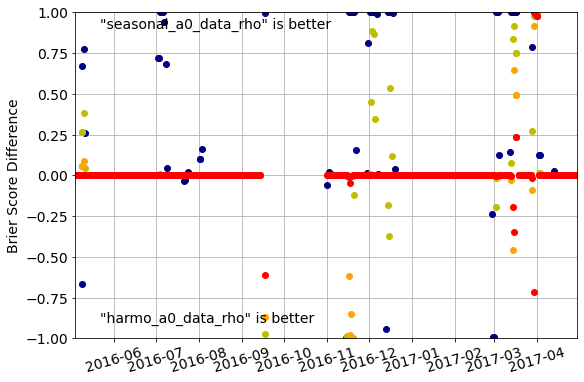

In [86]:
plt.figure(figsize=(9,6))
ax=plt.subplot(111)
top = 'seasonal_a0_data_rho'
bottom = 'harmo_a0_data_rho'
plt.plot(ds_A.time, calc_brier(load_vkdv(vkdvfiles[bottom]), 25) 
                - calc_brier(load_vkdv(vkdvfiles[top]), 25) ,'o',c='navy')

plt.plot(ds_A.time, calc_brier(load_vkdv(vkdvfiles[bottom]), 30) 
                - calc_brier(load_vkdv(vkdvfiles[top]), 30) ,'o',c='y')

plt.plot(ds_A.time, calc_brier(load_vkdv(vkdvfiles[bottom]), 35) 
                - calc_brier(load_vkdv(vkdvfiles[top]), 35) ,'o',c='orange')

plt.plot(ds_A.time, calc_brier(load_vkdv(vkdvfiles[bottom]), 40) 
                - calc_brier(load_vkdv(vkdvfiles[top]), 40) ,'o',c='r')

plt.text(0.05,0.95, '"{}" is better'.format(top), transform=ax.transAxes)
plt.text(0.05,0.05, '"{}" is better'.format(bottom), transform=ax.transAxes)

plt.ylabel('Brier Score Difference')
plt.ylim(-1,1)
plt.grid(b=True)
plt.xlim(ds.time[0],ds.time[-1])
plt.xticks(rotation=16)